# Predict risk premiums using Svensson residuals

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

Load Svensson curve residuals

In [2]:
df_sven_resid = pd.read_csv('Svensson residual daily.csv', index_col='date')

df_sven_resid.index = pd.PeriodIndex(df_sven_resid.index, freq='D')
df_sven_resid = df_sven_resid['1970-01-01':]

df_sven_resid.head(3)

,sven_resid
date,
1970-01-02,-0.317386
1970-01-05,-0.262637
1970-01-06,-0.253232


Compute month-end or month-average residuals

In [3]:
df_monthend = df_sven_resid.resample('M').last()
df_monthavg = df_sven_resid.resample('M').mean()

df_monthend.columns = ['sven_resid_end']
df_monthavg.columns = ['sven_resid_avg']

df_sven_resid_month = df_monthavg.join(df_monthend)

df_sven_resid_month.head()

,sven_resid_avg,sven_resid_end
date,,
1970-01,-0.095533,-0.149021
1970-02,-0.152244,0.194471
1970-03,-0.010531,-0.113244
1970-04,-0.039413,-0.164541
1970-05,-0.167970,-0.037586


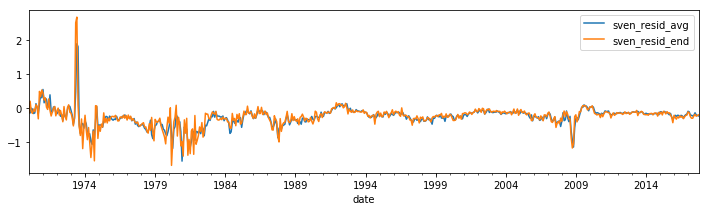

In [4]:
df_sven_resid_month.plot(figsize=(12,3))

Load excess returns and the CP tent factor

In [5]:
df_tent = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from CRSP/risk_premium_factors.dta')
df_tent = df_tent[['date', 'tent']]

df_exrets = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/excess_returns.dta')
df_exrets = pd.concat([df_exrets['date'], df_exrets.loc[:,'exret_annual2':'exret_annual15']], axis=1)

df_combined = df_tent.merge(df_exrets, on='date')

df_combined.index = pd.PeriodIndex(df_combined['date'], freq='M')
del df_combined['date']

df_combined.tail(3)

,tent,exret_annual2,exret_annual3,exret_annual4,exret_annual5,exret_annual6,exret_annual7,exret_annual8,exret_annual9,exret_annual10,exret_annual11,exret_annual12,exret_annual13,exret_annual14,exret_annual15
date,,,,,,,,,,,,,,,
2016-10,-0.000890,0.003562,0.009959,0.017552,0.025273,0.032554,0.039172,0.045103,0.050425,0.055254,0.059713,0.063908,0.067928,0.071842,0.075700
2016-11,0.009221,0.003874,0.007505,0.009618,0.010387,0.010313,0.009851,0.009312,0.008879,0.008640,0.008626,0.008834,0.009242,0.009823,0.010547
2016-12,0.008096,0.004592,0.008472,0.010609,0.011232,0.010859,0.009956,0.008856,0.007766,0.006802,0.006020,0.005438,0.005055,0.004862,0.004842


## Use the monthly residuals to predict risk premiums

In [6]:
df_combined = df_sven_resid_month.join(df_combined, how='left')
df_combined = sm.add_constant(df_combined)

df_combined.head(3)

,const,sven_resid_avg,sven_resid_end,tent,exret_annual2,exret_annual3,exret_annual4,exret_annual5,exret_annual6,exret_annual7,exret_annual8,exret_annual9,exret_annual10,exret_annual11,exret_annual12,exret_annual13,exret_annual14,exret_annual15
date,,,,,,,,,,,,,,,,,,
1970-01,1.0,-0.095533,-0.149021,0.007004,-0.018412,-0.036391,-0.053941,-0.070627,-0.086070,-0.099960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-02,1.0,-0.152244,0.194471,0.008012,-0.005126,-0.014530,-0.025518,-0.036195,-0.045350,-0.052290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-03,1.0,-0.010531,-0.113244,0.015299,-0.006246,-0.015758,-0.025602,-0.034449,-0.041824,-0.047683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Forecast: full sample

### Forecast: 3-year bonds, month-average residual, full sample

In [7]:
ols = sm.OLS(df_combined['exret_annual3'].shift(-12), df_combined[['const','tent','sven_resid_avg']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          exret_annual3   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     52.17
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           1.80e-21
Time:                        17:49:18   Log-Likelihood:                 1212.7
No. Observations:                 552   AIC:                            -2419.
Df Residuals:                     549   BIC:                            -2406.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0014      0.002      0.

### Forecast: 10-year bonds, month-average residual, full sample

In [8]:
ols = sm.OLS(df_combined['exret_annual10'].shift(-12), df_combined[['const','tent','sven_resid_avg']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         exret_annual10   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     75.16
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           1.83e-29
Time:                        17:49:18   Log-Likelihood:                 543.81
No. Observations:                 533   AIC:                            -1082.
Df Residuals:                     530   BIC:                            -1069.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0053      0.007     -0.

### Forecast: 3-year bonds, month-end residual, full sample

In [9]:
ols = sm.OLS(df_combined['exret_annual3'].shift(-12), df_combined[['const','tent','sven_resid_end']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          exret_annual3   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     52.62
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           1.24e-21
Time:                        17:49:18   Log-Likelihood:                 1213.1
No. Observations:                 552   AIC:                            -2420.
Df Residuals:                     549   BIC:                            -2407.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0003      0.002      0.

### Forecast: 10-year bonds, month-end residual, full sample

In [10]:
ols = sm.OLS(df_combined['exret_annual10'].shift(-12), df_combined[['const','tent','sven_resid_end']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         exret_annual10   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     74.93
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           2.19e-29
Time:                        17:49:18   Log-Likelihood:                 543.63
No. Observations:                 533   AIC:                            -1081.
Df Residuals:                     530   BIC:                            -1068.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0105      0.006     -1.

## Forecast: sub-sample analysis

### Forecast: 3-year bonds, month-average residual, pre-1989

In [11]:
subsample = df_combined[:'1989-12-31']

ols = sm.OLS(subsample['exret_annual3'].shift(-12), subsample[['const','tent','sven_resid_avg']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          exret_annual3   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     42.38
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           2.40e-16
Time:                        17:49:18   Log-Likelihood:                 468.01
No. Observations:                 228   AIC:                            -930.0
Df Residuals:                     225   BIC:                            -919.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0131      0.004     -3.

### Forecast: 3-year bonds, month-average residual, post-1990

In [12]:
subsample = df_combined['1990-01-01':]

ols = sm.OLS(subsample['exret_annual3'].shift(-12), subsample[['const','tent','sven_resid_avg']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          exret_annual3   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     17.16
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           8.59e-08
Time:                        17:49:18   Log-Likelihood:                 759.05
No. Observations:                 312   AIC:                            -1512.
Df Residuals:                     309   BIC:                            -1501.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0034      0.003      1.

### Forecast: 10-year bonds, month-average residual, pre-1989

In [13]:
subsample = df_combined[:'1989-12-31']

ols = sm.OLS(subsample['exret_annual10'].shift(-12), subsample[['const','tent','sven_resid_avg']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         exret_annual10   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     58.24
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           8.99e-21
Time:                        17:49:19   Log-Likelihood:                 186.39
No. Observations:                 209   AIC:                            -366.8
Df Residuals:                     206   BIC:                            -356.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0777      0.013     -6.

### Forecast: 10-year bonds, month-average residual, post-1990

In [14]:
subsample = df_combined['1990-01-01':]

ols = sm.OLS(subsample['exret_annual10'].shift(-12), subsample[['const','tent','sven_resid_avg']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         exret_annual10   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     31.05
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           5.16e-13
Time:                        17:49:19   Log-Likelihood:                 406.08
No. Observations:                 312   AIC:                            -806.2
Df Residuals:                     309   BIC:                            -794.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0112      0.010      1.

### Forecast: 3-year bonds, month-end residual, pre-1989

In [15]:
subsample = df_combined[:'1989-12-31']

ols = sm.OLS(subsample['exret_annual3'].shift(-12), subsample[['const','tent','sven_resid_end']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          exret_annual3   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     43.69
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           9.30e-17
Time:                        17:49:19   Log-Likelihood:                 468.97
No. Observations:                 228   AIC:                            -931.9
Df Residuals:                     225   BIC:                            -921.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0142      0.003     -4.

### Forecast: 3-year bonds, month-end residual, post-1990

In [16]:
subsample = df_combined['1990-01-01':]

ols = sm.OLS(subsample['exret_annual3'].shift(-12), subsample[['const','tent','sven_resid_end']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:          exret_annual3   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     18.03
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           3.93e-08
Time:                        17:49:19   Log-Likelihood:                 759.84
No. Observations:                 312   AIC:                            -1514.
Df Residuals:                     309   BIC:                            -1502.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0034      0.003      1.

### Forecast: 10-year bonds, month-end residual, pre-1989

In [17]:
subsample = df_combined[:'1989-12-31']

ols = sm.OLS(subsample['exret_annual10'].shift(-12), subsample[['const','tent','sven_resid_end']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         exret_annual10   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     59.88
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           3.17e-21
Time:                        17:49:19   Log-Likelihood:                 187.44
No. Observations:                 209   AIC:                            -368.9
Df Residuals:                     206   BIC:                            -358.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0779      0.011     -6.

### Forecast: 10-year bonds, month-end residual, post-1990

In [18]:
subsample = df_combined['1990-01-01':]

ols = sm.OLS(subsample['exret_annual10'].shift(-12), subsample[['const','tent','sven_resid_end']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:         exret_annual10   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     34.11
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           4.11e-14
Time:                        17:49:19   Log-Likelihood:                 408.64
No. Observations:                 312   AIC:                            -811.3
Df Residuals:                     309   BIC:                            -800.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0041      0.009      0.

## Forecast: Markov regime switch (only month-end residuals)

### 3-year T-bond excess returns

                        Markov Switching Model Results                        
Dep. Variable:          exret_annual3   No. Observations:                  552
Model:               MarkovRegression   Log Likelihood                1411.061
Date:                Wed, 08 Nov 2017   AIC                          -2804.121
Time:                        17:49:19   BIC                          -2765.299
Sample:                    01-31-1970   HQIC                         -2788.952
                         - 12-31-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0230      0.002    -11.592      0.000      -0.027      -0.019
x1             0.5246      0.089      5.911      0.0

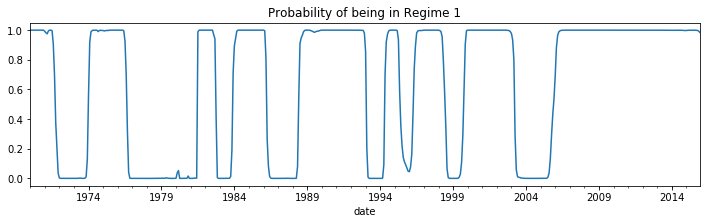

In [19]:
regime_model = sm.tsa.MarkovRegression(df_combined['exret_annual3'].shift(-12), exog=df_combined[['tent','sven_resid_end']], k_regimes=2, missing='drop')

regime_results = regime_model.fit()

print(regime_results.summary())

regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));

### 10-year T-bond excess returns

                        Markov Switching Model Results                        
Dep. Variable:         exret_annual10   No. Observations:                  533
Model:               MarkovRegression   Log Likelihood                 727.151
Date:                Wed, 08 Nov 2017   AIC                          -1436.303
Time:                        17:49:21   BIC                          -1397.796
Sample:                    08-31-1971   HQIC                         -1421.234
                         - 12-31-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0773      0.006    -12.198      0.000      -0.090      -0.065
x1             1.7454      0.264      6.615      0.0

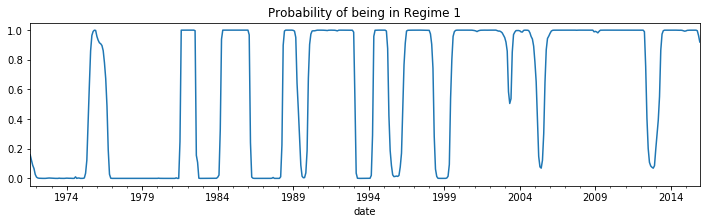

In [20]:
regime_model = sm.tsa.MarkovRegression(df_combined['exret_annual10'].shift(-12), exog=df_combined[['tent','sven_resid_end']], k_regimes=2, missing='drop')

regime_results = regime_model.fit()

print(regime_results.summary())

regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));

## Predict stock market excess returns

In [21]:
df_ff3factors = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Stocks/Fama_French/ff3factors_monthly.dta')

df_ff3factors.index = pd.PeriodIndex(df_ff3factors['date'], freq='M')

del df_ff3factors['date']

In [22]:
df_combined = df_sven_resid_month.join(df_ff3factors)
df_combined = sm.add_constant(df_combined)

df_combined.head(3)

,const,sven_resid_avg,sven_resid_end,mktrf,smb,hml,rf
date,,,,,,,
1970-01,1.0,-0.095533,-0.149021,-8.10,2.91,3.06,0.60
1970-02,1.0,-0.152244,0.194471,5.13,-2.38,4.03,0.62
1970-03,1.0,-0.010531,-0.113244,-1.06,-2.32,4.25,0.57


In [23]:
ols = sm.OLS(df_combined['mktrf'].shift(-1), df_combined[['const','sven_resid_end']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  mktrf   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.390
Date:                Wed, 08 Nov 2017   Prob (F-statistic):             0.0661
Time:                        17:49:22   Log-Likelihood:                -1659.3
No. Observations:                 567   AIC:                             3323.
Df Residuals:                     565   BIC:                             3331.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8449      0.248      3.

In [24]:
subsample = df_combined['1990-01-01':]

ols = sm.OLS(subsample['mktrf'].shift(-1), subsample[['const','sven_resid_end']], missing='drop')

print(ols.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  mktrf   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.958
Date:                Wed, 08 Nov 2017   Prob (F-statistic):             0.0864
Time:                        17:49:22   Log-Likelihood:                -935.48
No. Observations:                 327   AIC:                             1875.
Df Residuals:                     325   BIC:                             1883.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.2102      0.396      3.

                        Markov Switching Model Results                        
Dep. Variable:                  mktrf   No. Observations:                  567
Model:               MarkovRegression   Log Likelihood               -1626.240
Date:                Wed, 08 Nov 2017   AIC                           3268.480
Time:                        17:49:23   BIC                           3303.203
Sample:                    01-31-1970   HQIC                          3282.031
                         - 03-31-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7481      0.359      4.867      0.000       1.044       2.452
x1             4.0351      1.561      2.585      0.0

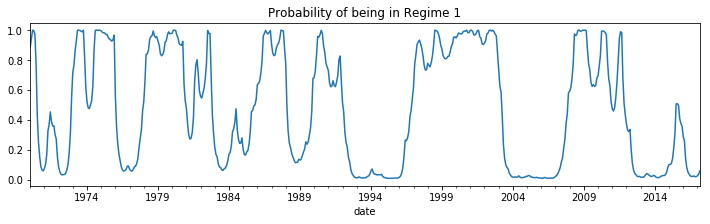

In [25]:
regime_model = sm.tsa.MarkovRegression(
    df_combined['mktrf'].shift(-1),
    exog=df_combined[['sven_resid_end']],
    k_regimes=2, missing='drop', switching_variance=True)

regime_results = regime_model.fit()

print(regime_results.summary())

regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));